In [60]:
# Ignore the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# System related and data input controls
import os

# Data manipulation, visualization and useful functions
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.max_rows = 50
pd.options.display.max_columns = 40
import numpy as np
from numpy import array
from itertools import product # iterative combinations
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling algorithms
# General(Statistics/Econometrics)
from sklearn import preprocessing
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats

# Evaluation metrics
# for regression
from sklearn.metrics import mean_squared_log_error, mean_squared_error,  r2_score, mean_absolute_error

# Keras
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Dense, Activation, Flatten, Dropout
from keras.layers import SimpleRNN, LSTM, GRU

In [62]:
# Data Loading
raw_2020 = pd.read_csv('/Users/kimjinseok/Desktop/work/data_science/kaflix_demand forecasting/csv/merged_wth_2020.csv', index_col='DT')
raw_2021 = pd.read_csv('/Users/kimjinseok/Desktop/work/data_science/kaflix_demand forecasting/csv/merged_wth_2021.csv', index_col='DT')
raw_2022 = pd.read_csv('/Users/kimjinseok/Desktop/work/data_science/kaflix_demand forecasting/csv/merged_wth_2022.csv', index_col='DT')

In [63]:
# Data Merge & datetime
raw_all = pd.concat([raw_2020, raw_2021, raw_2022])
raw_uni=raw_all.loc[:, ['ARRIVE_PPL']]
raw_uni.index = pd.to_datetime(raw_uni.index)
raw_uni=raw_uni.dropna()

In [64]:
# Data Loading
cvd19   = pd.read_csv('/Users/kimjinseok/Desktop/work/data_science/kaflix_demand forecasting/csv/0513/cvd19_ox_0513.csv')   # 코로나
wth     = pd.read_csv('/Users/kimjinseok/Desktop/work/data_science/kaflix_demand forecasting/csv/0513/wth_0513.csv')     # 기상 & 관광입도객(제주관광협회)
psg     = pd.read_csv('/Users/kimjinseok/Desktop/work/data_science/kaflix_demand forecasting/csv//0513/psg_0513.csv')     # 공합입도객수
sch     = pd.read_csv('/Users/kimjinseok/Desktop/work/data_science/kaflix_demand forecasting/csv/0513/search_0513.csv')     # 검색량

#rnt     = pd.read_csv('/Users/kimjinseok/Desktop/work/data_science/kaflix_demand forecasting/csv/rnt.csv')     # 렌트카
#cpt_prc = pd.read_csv('/Users/kimjinseok/Desktop/kaflix_demand forecasting/csv/cpt_prc.csv') # 경쟁사 가격
#mk_sr   = pd.read_csv('/Users/kimjinseok/Desktop/kaflix_demand forecasting/csv/mk_sr.csv')   # 시장점유율
#air_tck = pd.read_csv('/Users/kimjinseok/Desktop/kaflix_demand forecasting/csv/air_tck.csv') # 예매 가능한 비행티켓(인터파크)
#prm     = pd.read_csv('/Users/kimjinseok/Desktop/kaflix_demand forecasting/csv/prm.csv')     # 프로모션

# Datetime 
cvd19['date']=pd.to_datetime(cvd19['date'])
wth['DT']=pd.to_datetime(wth['DT'])
psg['DT']=pd.to_datetime(psg['DT'])
sch['period']=pd.to_datetime(sch['period'])
cvd19=cvd19[cvd19['location']=='South Korea']

# psg   : 2019-05-01 ~ 2022-04-28 제주공항 입도객수
# cvd19 : 2020-01-22 ~ 2022-05-12 코로나 거리두기 정책지수
# sch   : 2019-05-14 ~ 2022-05-13 '제주렌트카' 검색량
# wth   : 2017-01-01 ~ 2022-12-25 날씨 및 공휴일
# 모두 겹치는 일정 2019-05-14(코로나 제외) ~ 2022-04-28

# psg에 모든 주에 데이터 있는지 검증 => 20190-05-01부터 2022-04-28까지는 1094일
#len(psg['DT'].unique()) 

# Indexing pgs date & left join with other data
psg = psg.sort_values("DT")
psg.set_index("DT", inplace=True)
psg = psg.loc[psg.index >= '2019-05-14',:]  # 0513까지 삭제
psg = psg.groupby("DT")['ARRIVE_PPL'].sum() # 일별 입도객 합계
psg = pd.DataFrame(psg)                     # 데이터프레임만들고
cvd19.rename(columns={'date':'DT'}, inplace=True)
sch.rename(columns={'period':'DT'}, inplace=True)

# Select Required Data
cvd19 = cvd19[['DT', 'stringency_index', 'new_tests_per_thousand', 'total_vaccinations_per_hundred', 'total_boosters_per_hundred']] 
wth = wth[['DT','TEMPERTURE','RAIN','HOLIDAY_NAME']]

# merge psg & cvd19
merged = pd.merge(psg, cvd19, on="DT", how="left")

# holiday preprocessing for long and interspersed
wth_h = wth[['DT', 'HOLIDAY_NAME']]

# 1 for 'Lunar New Years' and 'Chuseok' & other holidays 
#wth_h['wth_m']=np.where((wth_h['HOLIDAY_NAME']=='설날') | (wth_h['HOLIDAY_NAME']=='추석'), 1, 0)
wth_h.HOLIDAY_NAME.loc[~wth_h.HOLIDAY_NAME.isnull()] = 1
wth_h = wth_h.sort_values('DT')
wth_h.HOLIDAY_NAME.loc[wth_h.HOLIDAY_NAME.isnull()] = 0
#wth_h['HOLIDAY_NAME']=wth_h['HOLIDAY_NAME'] + wth_h['wth_m']
#wth_h.HOLIDAY_NAME.unique()

In [65]:
# [long holidays] and [Holidays Interspersed with Workdays]
wth_h['dayofweek'] = wth_h.DT.dt.dayofweek

# 공휴일인데 금요일(4)이면 그주 금요일(4)을 연휴시작으로
# 공휴일인데 월요일(0)이면 전주 토요일(5)을 연휴시작으로
wth_h['flong']=np.where((wth_h['HOLIDAY_NAME'] == 1) & (wth_h['dayofweek'] == 4), 1, 0)
wth_h['mlong']=np.where((wth_h['HOLIDAY_NAME'] == 1) & (wth_h['dayofweek'] == 0), 1, 0)

#월요일 연휴는 그 전 토요일에 연휴 시작 표시
wth_h['mlong']= wth_h['mlong'].shift(-2)
wth_h['mlong'].fillna(method='ffill', inplace = True)

#금요일 연휴, 월요일 연휴 컬럼 합치기
wth_h['long_h']=wth_h['flong'] + wth_h['mlong'] 

#연휴시작 하루 전날 표시
wth_h['b_long_h']=wth_h['long_h'].shift(-1)
wth_h['b_long_h'].fillna(method='ffill', inplace = True)

# 징검다리 로직
# 휴일인데 목요일(3)이면 그주 목요일(3)을 징검다리 연휴시작
# 휴일인데 화요일(1)이면 전주 토요일(5)을 징검다리 연휴시작
wth_h['thinter'] = np.where((wth_h['HOLIDAY_NAME'] == 1) & (wth_h['dayofweek'] == 3), 1, 0)
wth_h['tuinter'] = np.where((wth_h['HOLIDAY_NAME'] == 1) & (wth_h['dayofweek'] == 1), 1, 0)

# 화요일 징검다리는 전주 토요일에 연휴 시작 표시
wth_h['tuinter'] = wth_h['tuinter'].shift(-3)
wth_h['tuinter'].fillna(method='ffill', inplace = True)
wth_h['inter_h'] = wth_h['thinter'] + wth_h['tuinter'] 

# 징검다리 시작 하루 전날 표시
wth_h['b_inter_h'] = wth_h['inter_h'].shift(-1)
wth_h['b_inter_h'].fillna(method='ffill', inplace = True)


In [66]:
# [first day of myeojeol] 
#holiday    : 설날/추석 명절 -> 1
#first_m    : 설날/추석 명절연휴 시작일,단 명절 연휴시작이 (일) 또는 (월)이면 (토)가 시작일 -> 1 표시
#b_first_m  : 설날/추석 명절연휴 시작일 전날, 단 명절 연휴시작이 (일) 또는 (월)이면 (금)이 시작일 전날 -> 1로 표시b

In [67]:
#first_m    : 설날/추석 명절연휴 시작일,단 명절 연휴시작이 (일) 또는 (월)이면 (토)가 시작일 -> 1 표시
#2017-01-27, 2017-10-03, 2018-02-15, 2018-09-23, 2019-02-04, 2019-09-12, 2020-01-24, 2020-09-30, 2021-02-11, 2021-09-30, 2022-02-01

#first_m_nosm   : 설날/추석 명절연휴 시작일,단 명절 연휴시작이 (화) 또는 (수) 또는 (목) 또는 (금) 또는 (토) 이면 1
wth_h['first_m_nosm']=np.where(((wth_h['DT'] == '2017-01-27') |
                          (wth_h['DT'] == '2017-10-03') |
                          (wth_h['DT'] == '2018-02-15') |
                          (wth_h['DT'] == '2018-09-23') |
                          (wth_h['DT'] == '2019-02-04') |
                          (wth_h['DT'] == '2019-09-12') |
                          (wth_h['DT'] == '2020-01-24') |
                          (wth_h['DT'] == '2020-09-30') |
                          (wth_h['DT'] == '2021-02-11') |
                          (wth_h['DT'] == '2021-09-20') |
                          (wth_h['DT'] == '2022-01-31') )
                          & ((wth_h['dayofweek'] != 6) & (wth_h['dayofweek'] !=0)), 1,0)

#first_m_s   : 설날/추석 명절연휴 시작일,단 명절 연휴시작이 (일)이면 1로 표시하고 shift -1
wth_h['first_m_s']=np.where(((wth_h['DT'] == '2017-01-27') |
                          (wth_h['DT'] == '2017-10-03') |
                          (wth_h['DT'] == '2018-02-15') |
                          (wth_h['DT'] == '2018-09-23') |
                          (wth_h['DT'] == '2019-02-04') |
                          (wth_h['DT'] == '2019-09-12') |
                          (wth_h['DT'] == '2020-01-24') |
                          (wth_h['DT'] == '2020-09-30') |
                          (wth_h['DT'] == '2021-02-11') |
                          (wth_h['DT'] == '2021-09-20') |
                          (wth_h['DT'] == '2022-01-31') )
                          & (wth_h['dayofweek'] == 6), 1,0)
wth_h['first_m_s'] = wth_h['first_m_s'].shift(-1)
wth_h['first_m_s'].fillna(method='ffill', inplace = True)

#first_m_m   : 설날/추석 명절연휴 시작일,단 명절 연휴시작이 (월)이면 1로 표시하고 shift -2
wth_h['first_m_m']=np.where(((wth_h['DT'] == '2017-01-27') |
                          (wth_h['DT'] == '2017-10-03') |
                          (wth_h['DT'] == '2018-02-15') |
                          (wth_h['DT'] == '2018-09-23') |
                          (wth_h['DT'] == '2019-02-04') |
                          (wth_h['DT'] == '2019-09-12') |
                          (wth_h['DT'] == '2020-01-24') |
                          (wth_h['DT'] == '2020-09-30') |
                          (wth_h['DT'] == '2021-02-11') |
                          (wth_h['DT'] == '2021-09-20') |
                          (wth_h['DT'] == '2022-01-31') )
                          & (wth_h['dayofweek'] == 0), 1,0)
wth_h['first_m_m'] = wth_h['first_m_m'].shift(-2)
wth_h['first_m_m'].fillna(method='ffill', inplace = True)

wth_h['first_m'] = wth_h['first_m_nosm'] + wth_h['first_m_s'] + wth_h['first_m_m']

wth_h['b_first_m'] = wth_h['first_m'].shift(-1)
wth_h['b_first_m'].fillna(method='ffill', inplace=True)


In [68]:
wth_h.columns

Index(['DT', 'HOLIDAY_NAME', 'dayofweek', 'flong', 'mlong', 'long_h',
       'b_long_h', 'thinter', 'tuinter', 'inter_h', 'b_inter_h',
       'first_m_nosm', 'first_m_s', 'first_m_m', 'first_m', 'b_first_m'],
      dtype='object')

In [69]:
wth_h.drop(['flong', 'mlong', 'thinter','tuinter', 'first_m_nosm','first_m_s', 'first_m_m'], axis=1, inplace=True)

In [70]:
# merge wether & searching data 
wth=wth[['DT','TEMPERTURE','RAIN']]
wth=pd.merge(wth, wth_h, how='left', on='DT')
merged=pd.merge(merged, wth, on="DT", how="left")
merged=pd.merge(merged, sch, on='DT', how='left')
merged

# columns rename
merged.columns = ['datetime' , 'count', 'cvd_index', 'new_test', 'total_vaccin', 'total_booster' ,'temperature', 'rain', 'holiday', 'dayofweek','long_h','b_long_h','inter_h','b_inter_h','first_m','b_first_m','search']

# nan to zero
cvd_cols = ['cvd_index', 'new_test', 'total_vaccin', 'total_booster']
merged[cvd_cols] = merged[cvd_cols].replace({np.nan:0})

In [78]:
# feature engineering for time-series
def feature_engineering(raw):
    if 'datetime' in raw.columns:
        raw['DateTime'] = pd.to_datetime(raw['datetime'])
    if raw.index.dtype == 'int64':
        raw.set_index('DateTime', inplace=True)

    # decompose trend / seasonal data 
    decompose=sm.tsa.seasonal_decompose(raw['count'], model='additive')
    decompose.plot()

    # add trend data 
    Y_trend=pd.DataFrame(decompose.trend)
    Y_trend.fillna(method='ffill', inplace=True)
    Y_trend.fillna(method='bfill', inplace=True)
    Y_trend.columns=['count_trend']
    raw = pd.concat([raw, Y_trend], axis=1)
    
    # add seasonal data 
    Y_seasonal = pd.DataFrame(decompose.seasonal)
    Y_seasonal.fillna(method='ffill', inplace=True)
    Y_seasonal.fillna(method='bfill', inplace=True)
    Y_seasonal.columns=['count_seasonal']
    raw = pd.concat([raw, Y_seasonal], axis=1)
    
    # add weekly data 
    Y_count_Week = raw[['count']].rolling(7).mean()
    Y_count_Week.fillna(method='ffill', inplace=True)
    Y_count_Week.fillna(method='bfill', inplace=True)
    Y_count_Week.columns=['count_Week']
    raw = pd.concat([raw, Y_count_Week], axis=1)
    
    # add difference data 
    Y_diff = raw[['count']].diff()
    Y_diff.fillna(method='ffill', inplace=True)
    Y_diff.fillna(method='bfill', inplace=True)
    Y_diff.columns = ['count_diff']
    raw = pd.concat([raw, Y_diff], axis=1)

    # add time series data 
    raw['year']       = raw.datetime.dt.year
    raw['quarter']    = raw.datetime.dt.quarter
    raw['month']      = raw.datetime.dt.month
    raw['count_lag1'] = raw['count'].shift(1)
    raw['count_lag1'].fillna(method = 'bfill', inplace=True)
    raw['count_lag2'] = raw['count'].shift(2)
    raw['count_lag2'].fillna(method = 'bfill', inplace=True)


    # dummy 변수(카테고리 변수) => holiday(0,1) / dayofweek(0,1,2,3,4,5,6) / long_h(0,1) / b_long_h(0,1) / inter_h(0,1) / b_inter_h(0,1) 
    #                         /first_m(0,1)/ b_first_m(0,1) / year(2019,2020,2021,2022) / month(1~12) / quarter(1~4)

    raw = pd.concat([raw, pd.get_dummies(raw['holiday'], prefix='holiday' + '_dummy')], axis=1)
    raw = pd.concat([raw, pd.get_dummies(raw['dayofweek'], prefix='dayofweek' + '_dummy')], axis=1)
    raw = pd.concat([raw, pd.get_dummies(raw['long_h'], prefix='long_h' + '_dummy')], axis=1)
    raw = pd.concat([raw, pd.get_dummies(raw['b_long_h'], prefix='b_long_h' + '_dummy')], axis=1)
    raw = pd.concat([raw, pd.get_dummies(raw['inter_h'], prefix='inter_h' + '_dummy')], axis=1)
    raw = pd.concat([raw, pd.get_dummies(raw['b_inter_h'], prefix='b_inter_h' + '_dummy')], axis=1)
    raw = pd.concat([raw, pd.get_dummies(raw['first_m'], prefix='first_m' + '_dummy')], axis=1)
    raw = pd.concat([raw, pd.get_dummies(raw['b_first_m'], prefix='b_first_m' + '_dummy')], axis=1)
    raw = pd.concat([raw, pd.get_dummies(raw['year'], prefix='year' + '_dummy')], axis=1)
    raw = pd.concat([raw, pd.get_dummies(raw['month'], prefix='month' + '_dummy')], axis=1)
    raw = pd.concat([raw, pd.get_dummies(raw['quarter'], prefix='quarter' + '_dummy')], axis=1)

    raw = raw.drop(columns=['holiday', 'dayofweek', 'long_h', 'b_long_h', 'inter_h', 'b_inter_h','first_m','b_first_m', 'year', 'month', 'quarter'])
    
    raw_fe = raw.copy() 
    return raw_fe

# Reality _ feature_engineering_year_duplicated
# target = ['count_trend', 'count_seasonal', 'count_Week', 'count_diff']

def feature_engineering_year_duplicated(raw, target):
    raw_fe = raw.copy()
    for col in target:
        raw_fe.loc['2021-04-29':'2022-04-28', col] = raw_fe.loc['2020-04-29':'2021-04-28', col].values
    return raw_fe

# Y_colname = ['count']
# X_remove = ['datetime', 'DateTime']
# X_colname = [x for x in merged.columns if x not in Y_colname + X_remove]
# Data Split for time series
def datasplit_ts(raw, Y_colname, X_colname, criteria):
    X_colname = [x for x in raw.columns if x not in Y_colname + X_remove]

    raw_train = raw.loc[merged.index < criteria, :]
    raw_test  = raw.loc[merged.index >= criteria, :]
    Y_train   = raw_train[Y_colname]
    X_train   = raw_train[X_colname]
    Y_test    = raw_test[Y_colname]
    X_test    = raw_test[X_colname]
    print('Train_size:', raw_train.shape, 'Test_size:', raw_test.shape)
    print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
    print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)
    return X_train, X_test, Y_train, Y_test

# modify lagged values of X_test
# target = ['count_lag1', 'count_lag2']
def feature_engineering_lag_modified(Y_test, X_test, target):
    X_test_lm = X_test.copy()
    i = 1
    for col in target:
        X_test_lm[col] = Y_test.shift(i).values
        X_test_lm[col].fillna(method='bfill', inplace=True)
        i = i + 1
    return X_test_lm
    


Train_size: (1021, 57) Test_size: (60, 57)
X_train: (1021, 54) Y_train: (1021, 1)
X_test: (60, 54) Y_test: (60, 1)


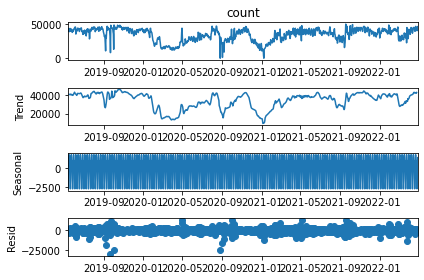

In [79]:
# Feature Engineering
merged_fe  = feature_engineering(merged)

# Reality _ feature_engineering_year_duplicated
target_d  = ['count_trend', 'count_seasonal', 'count_Week', 'count_diff']
merged_feR = feature_engineering_year_duplicated(merged_fe, target_d)

# Data Split
# Confirm of input and output
Y_colname = ['count']
X_remove = ['datetime', 'DateTime']
X_colname = [x for x in merged_fe.columns if x not in Y_colname + X_remove]
X_train_feR, X_test_feR, Y_train_feR, Y_test_feR = datasplit_ts(merged_feR, Y_colname, X_colname, '2022-02-28')


# Reality _ modify lagged values of X_test
target_l = ['count_lag1', 'count_lag2']
X_test_feR = feature_engineering_lag_modified(Y_test_feR, X_test_feR, target_l)


In [77]:
X_test_feR 

,cvd_index,new_test,total_vaccin,total_booster,temperature,rain,search,count_trend,count_seasonal,count_Week,count_diff,count_lag1,count_lag2,holiday_dummy_0,holiday_dummy_1,dayofweek_dummy_0,dayofweek_dummy_1,dayofweek_dummy_2,dayofweek_dummy_3,dayofweek_dummy_4,...,year_dummy_2019,year_dummy_2020,year_dummy_2021,year_dummy_2022,month_dummy_1,month_dummy_2,month_dummy_3,month_dummy_4,month_dummy_5,month_dummy_6,month_dummy_7,month_dummy_8,month_dummy_9,month_dummy_10,month_dummy_11,month_dummy_12,quarter_dummy_1,quarter_dummy_2,quarter_dummy_3,quarter_dummy_4
DateTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-02-28,46.30,8.91,232.53,61.47,8.70,0.00,12600,"30,927.43",869.33,"34,885.71","-12,115.00","27,432.00","27,432.00",1,0,1,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2022-03-01,40.74,20.83,232.54,61.48,10.10,3.80,14600,"29,703.71",-578.84,"33,416.14","-6,265.00","27,432.00","27,432.00",0,1,0,1,0,0,0,...,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
2022-03-02,40.74,10.73,232.70,61.63,6.40,0.00,15200,"28,576.71","-2,703.27","32,363.71","1,130.00","25,339.00","27,432.00",1,0,0,0,1,0,0,...,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
2022-03-03,40.74,16.68,232.87,61.79,10.00,0.00,14400,"26,733.71","-1,378.30","30,927.43","-2,356.00","25,931.00","25,339.00",1,0,0,0,0,1,0,...,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
2022-03-04,40.74,16.98,233.12,62.02,12.60,0.00,13400,"26,618.00","1,311.82","29,703.71","1,594.00","25,266.00","25,931.00",1,0,0,0,0,0,1,...,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-24,16.67,1.79,237.71,66.09,17.70,0.00,19500,"39,370.43",792.09,"39,507.71",-609.00,"43,690.00","46,166.00",1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
2022-04-25,16.67,1.53,238.12,66.50,21.20,14.80,23800,"39,242.57",869.33,"39,623.29",-437.00,"44,094.00","43,690.00",1,0,1,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
2022-04-26,16.67,5.21,238.56,66.93,19.30,25.80,22400,"39,077.43",-578.84,"39,532.71","-3,023.00","40,827.00","44,094.00",1,0,0,1,0,0,0,...,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0


In [80]:
# Parameters
scaler_X_tr = preprocessing.MinMaxScaler()
scaler_Y_tr = preprocessing.MinMaxScaler()
batch_size = 32
n_steps_in = 24
n_steps_out = 7
epoch = 30
verbose = 1
dropout_ratio = 0

# Scaling
Y_train_scaled = scaler_Y_tr.fit_transform(Y_train)
Y_test_scaled  = scaler_Y_tr.transform(Y_test)

print('Y_train_scaled:', Y_train_scaled.shape, 'Y_test_scaled:', Y_test_scaled.shape)

Y_train_scaled: (1021, 1) Y_test_scaled: (60, 1)


In [81]:
## X/Y Split
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
    # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
    # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [82]:
train_X, train_Y, = split_sequence(Y_train_scaled, 24, 7)

In [83]:
test_X, test_Y = split_sequence(Y_test_scaled, 24, 7)

In [84]:
print('train_X:', train_X.shape, 'train_Y:', train_Y.shape)
print('test_X:', test_X.shape, 'test_Y:', test_Y.shape)

train_X: (991, 24, 1) train_Y: (991, 7, 1)
test_X: (30, 24, 1) test_Y: (30, 7, 1)


In [85]:
# # Parameters
# criteria = '2022-02-28'
# scaler = preprocessing.MinMaxScaler()
# sequence = 30
# batch_size = 16
# epoch = 20
# verbose = 1
# dropout_ratio = 0

# # Feature Engineering
# ## Train & Test Split
# train = raw_uni.loc[raw_uni.index < criteria, :]
# test = raw_uni.loc[raw_uni.index >= criteria, :]
# print('Train_size:', train.shape, 'Test_size:', test.shape)

# ## Scaling
# train_scaled = scaler.fit_transform(train)
# test_scaled = scaler.transform(test)

# ## X/Y Split
# X_train, Y_train = [], []
# X_test, Y_test = [], []

# ## X / Y Split
# for index in range(len(train_scaled) - sequence):
#     X_train.append(train_scaled[index: index + sequence])
#     Y_train.append(train_scaled[index + sequence])
# for index in range(len(test_scaled) - sequence):
#     X_test.append(test_scaled[index: index + sequence])
#     Y_test.append(test_scaled[index + sequence])         

# ## Retype and Reshape
# X_train, Y_train = np.array(X_train), np.array(Y_train)
# X_test, Y_test = np.array(X_test), np.array(Y_test)
# print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
# print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)

# # RNN
# model = Sequential()
# model.add(SimpleRNN(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, activation='relu'))
# model.add(Dropout(dropout_ratio)) 
# model.add(SimpleRNN(256, return_sequences=True, activation="relu"))
# model.add(Dropout(dropout_ratio)) 
# model.add(SimpleRNN(128, return_sequences=True, activation="relu"))
# model.add(Dropout(dropout_ratio)) 
# model.add(SimpleRNN(64, return_sequences=True, activation="relu"))
# model.add(Dropout(dropout_ratio)) 
# model.add(Flatten())
# model.add(Dense(1))
# model.compile(optimizer='adam', loss='mean_squared_error')
# model.summary()
# model_fit = model.fit(X_train, Y_train, 
#                       batch_size=batch_size, epochs=epoch,
#                       verbose=verbose)

# plt.plot(pd.DataFrame(model_fit.history))
# plt.grid(True)
# plt.show()

# # prediction
# Y_train_pred = model.predict(X_train)
# Y_test_pred = model.predict(X_test)

# # evaluation
# result = model.evaluate(X_test, Y_test_pred)
# if scaler != []:
#     Y_train = scaler.inverse_transform(Y_train)
#     Y_train_pred = scaler.inverse_transform(Y_train_pred)
#     Y_test = scaler.inverse_transform(Y_test)
#     Y_test_pred = scaler.inverse_transform(Y_test_pred)
# Score_RNN, Residual_tr, Residual_te = evaluation_trte(pd.DataFrame(Y_train), Y_train_pred.flatten(), 
#                                                       pd.DataFrame(Y_test), Y_test_pred.flatten(), graph_on=True)
# display(Score_RNN)


## LSTM

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 24, 128)           66560     
                                                                 
 dropout_8 (Dropout)         (None, 24, 128)           0         
                                                                 
 lstm_5 (LSTM)               (None, 24, 256)           394240    
                                                                 
 dropout_9 (Dropout)         (None, 24, 256)           0         
                                                                 
 lstm_6 (LSTM)               (None, 24, 128)           197120    
                                                                 
 dropout_10 (Dropout)        (None, 24, 128)           0         
                                                                 
 lstm_7 (LSTM)               (None, 64)               

2022-06-07 17:35:22.690785: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


31/31 [==============================] - 131s 4s/step - loss: 0.1563
Epoch 2/30
31/31 [==============================] - 127s 4s/step - loss: 0.0225
Epoch 3/30
31/31 [==============================] - 126s 4s/step - loss: 0.0192
Epoch 4/30
31/31 [==============================] - 126s 4s/step - loss: 0.0191
Epoch 5/30
31/31 [==============================] - 127s 4s/step - loss: 0.0190
Epoch 6/30
31/31 [==============================] - 127s 4s/step - loss: 0.0184
Epoch 7/30
31/31 [==============================] - 127s 4s/step - loss: 0.0194
Epoch 8/30
31/31 [==============================] - 126s 4s/step - loss: 0.0192
Epoch 9/30
31/31 [==============================] - 128s 4s/step - loss: 0.0181
Epoch 10/30
31/31 [==============================] - 127s 4s/step - loss: 0.0191
Epoch 11/30
31/31 [==============================] - 129s 4s/step - loss: 0.0173
Epoch 12/30
31/31 [==============================] - 129s 4s/step - loss: 0.0187
Epoch 13/30
31/31 [=============================

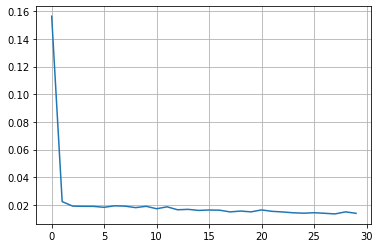

2022-06-07 18:21:35.102867: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [86]:
# LSTM
model = Sequential()
model.add(LSTM(128, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True, activation='relu'))
model.add(Dropout(dropout_ratio)) 
model.add(LSTM(256, return_sequences=True, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(LSTM(128, return_sequences=True, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(LSTM(64, return_sequences=False, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()
model_fit = model.fit(train_X, train_Y, 
                      batch_size=batch_size, epochs=epoch,
                      verbose=verbose)

plt.plot(pd.DataFrame(model_fit.history))
plt.grid(True)
plt.show()

# prediction
train_Y_pred = model.predict(train_X)
test_Y_pred = model.predict(test_X)

In [87]:
print('train_X:', train_X.shape, 'train_Y:', train_Y.shape, 'train_Y_pred:', train_Y_pred.shape)
print('test_X:', test_X.shape, 'test_Y:', test_Y.shape, 'test_Y_pred:', test_Y_pred.shape)

train_X: (991, 24, 1) train_Y: (991, 7, 1) train_Y_pred: (991, 7)
test_X: (30, 24, 1) test_Y: (30, 7, 1) test_Y_pred: (30, 7)


In [88]:
test_Y_pred.shape

(30, 7)

In [89]:
# evaluataion function 
def prep_data(y_test, y_pred, start , end , last):
    # 24 past days and real future 7 days value
    y_test = scaler_Y_tr.inverse_transform(y_test)
    past_24_real = y_test[:end , :]
    ftre_07_real = y_test[end:last , :]
    # predict 7 days value
    y_pred = scaler_Y_tr.inverse_transform(y_pred)
    ftre_07_pred = y_pred[start, :]
    ftre_07_pred = ftre_07_pred.reshape(n_steps_out,1)
    return ftre_07_pred , ftre_07_real , past_24_real

# Calculate MAE and RMSE and MAPE
def evaluate_prediction(predictions, actual , start , end):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()
    mape = (np.abs(errors)/actual*100).mean()

    print("Test Data from {} to {}".format(start, end))
    print('Mean Absolute Error: {:.2f}'.format(mae))
    #print('Root Mean Squared Error: {:.2f}'.format(RMSE))
    print('Mean Absolute Percenatge Error: {:.2f}'.format(mape))
    print('')
    print('')

In [90]:
# Plot history and future
def plot_multistep(past, predict , real , start , end):
    plt.figure(figsize=(20, 4))
    y_mean = np.mean(pred7)
    range_past = len(past24)
    range_future = list(range(range_past, range_past + len(pred7)))
    plt.plot(np.arange(range_past), np.array(past24), label='past')
    plt.plot(range_future, np.array(pred7),label='Forecasted with LSTM')
    plt.plot(range_future, np.array(real7),label='Y_actual')
    plt.legend(loc='lower right')
    plt.title("Test Data from {} to {} , Mean = {:.2f}".format(start, end, y_mean) ,  fontsize=18)
    plt.xlabel('Time step' ,  fontsize=18)
    plt.ylabel('y-value' , fontsize=18)

Test Data from 0 to 24
Mean Absolute Error: 6162.83
Mean Absolute Percenatge Error: 18.58


Test Data from 1 to 25
Mean Absolute Error: 6541.92
Mean Absolute Percenatge Error: 19.94


Test Data from 2 to 26
Mean Absolute Error: 6461.49
Mean Absolute Percenatge Error: 16.92


Test Data from 3 to 27
Mean Absolute Error: 5515.10
Mean Absolute Percenatge Error: 15.04


Test Data from 4 to 28
Mean Absolute Error: 5705.81
Mean Absolute Percenatge Error: 15.32


Test Data from 5 to 29
Mean Absolute Error: 6004.84
Mean Absolute Percenatge Error: 16.19


Test Data from 6 to 30
Mean Absolute Error: 5548.85
Mean Absolute Percenatge Error: 14.71


Test Data from 7 to 31
Mean Absolute Error: 5184.66
Mean Absolute Percenatge Error: 13.14


Test Data from 8 to 32
Mean Absolute Error: 5810.09
Mean Absolute Percenatge Error: 14.44


Test Data from 9 to 33
Mean Absolute Error: 6064.96
Mean Absolute Percenatge Error: 14.83


Test Data from 10 to 34
Mean Absolute Error: 6095.31
Mean Absolute Percenatge Er

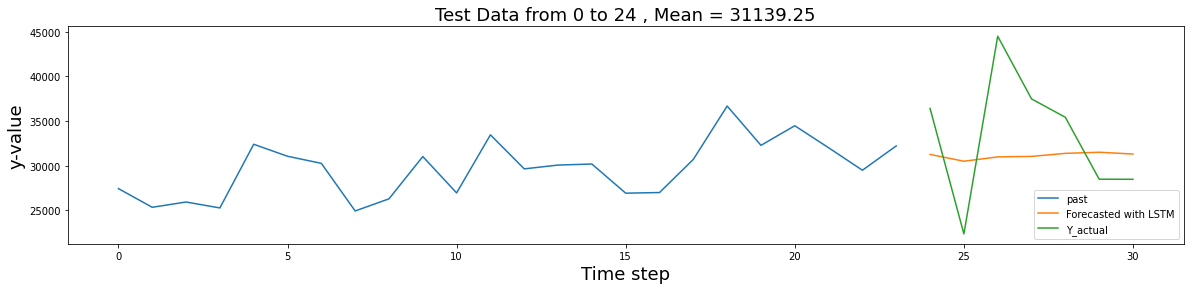

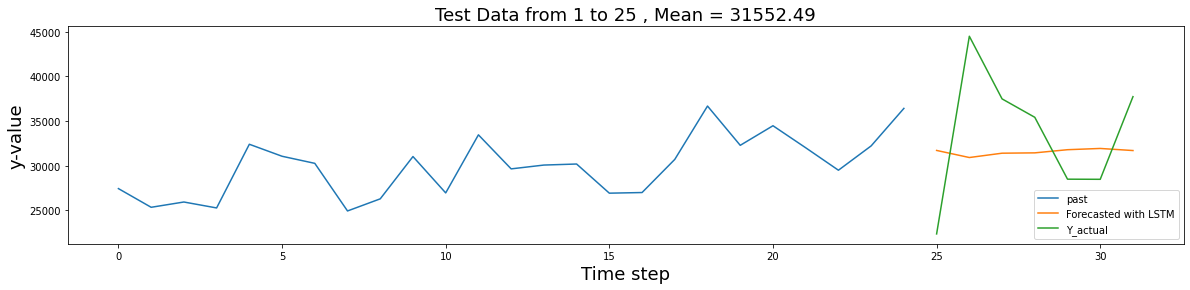

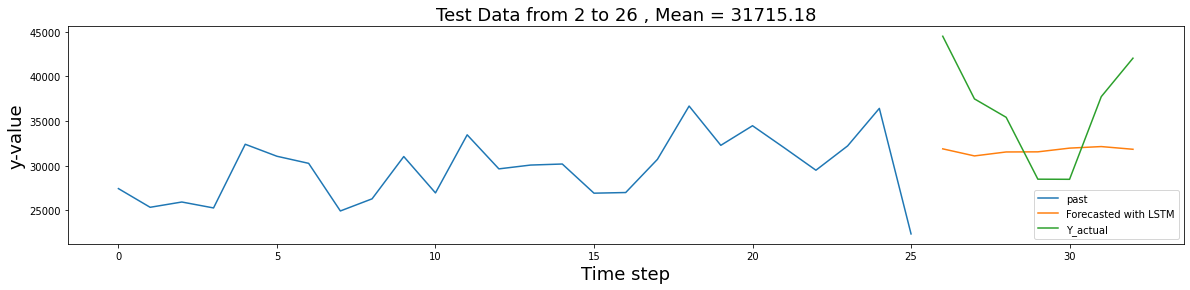

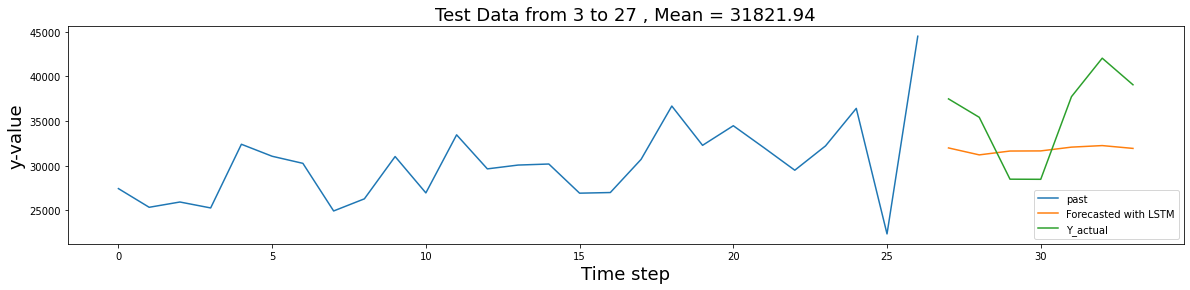

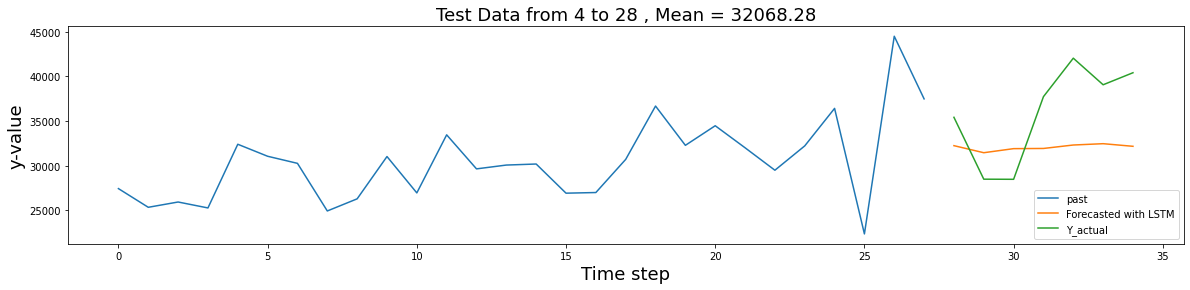

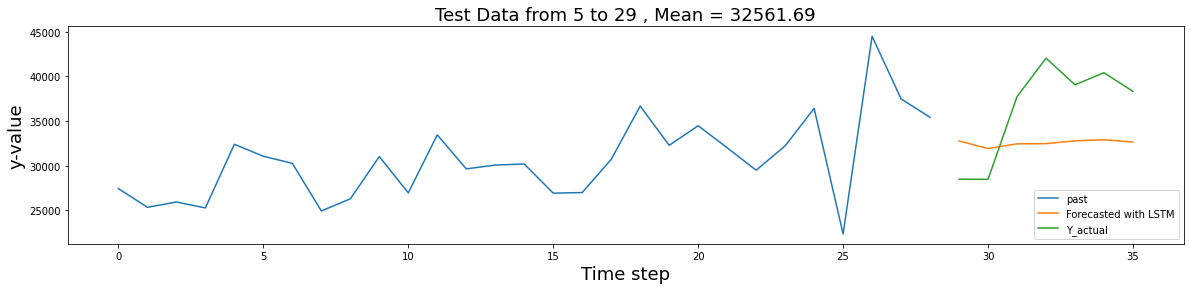

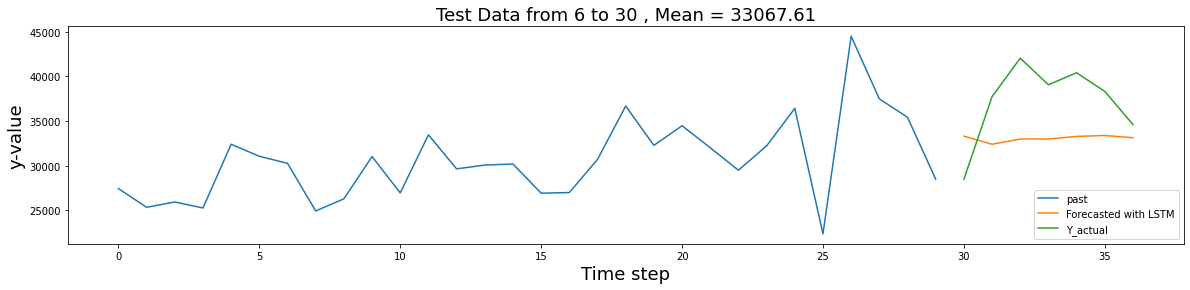

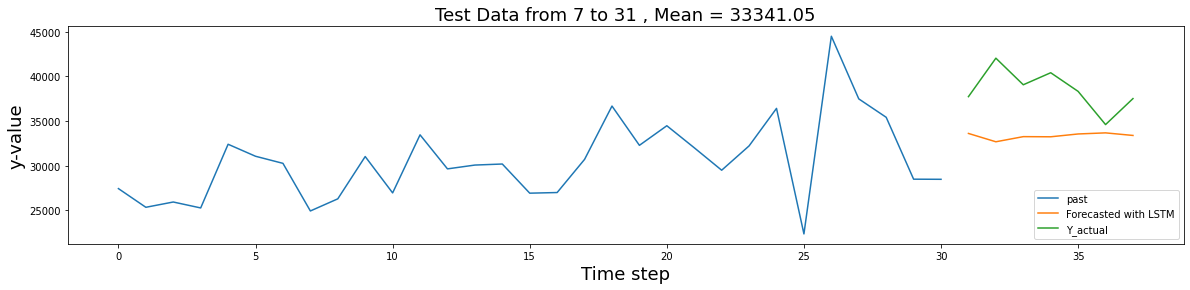

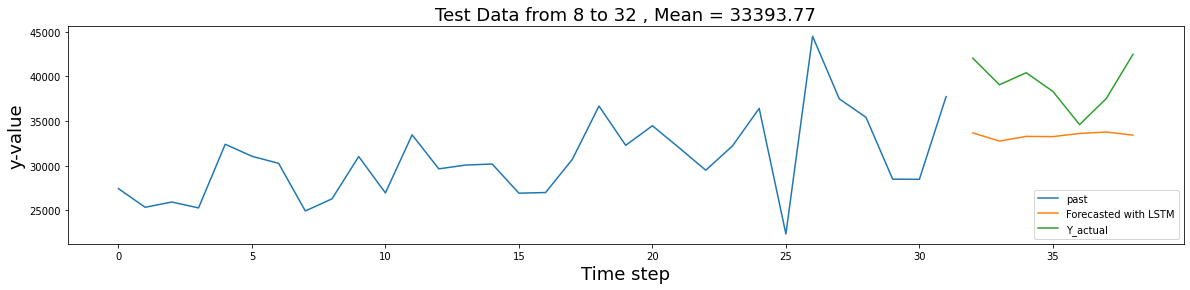

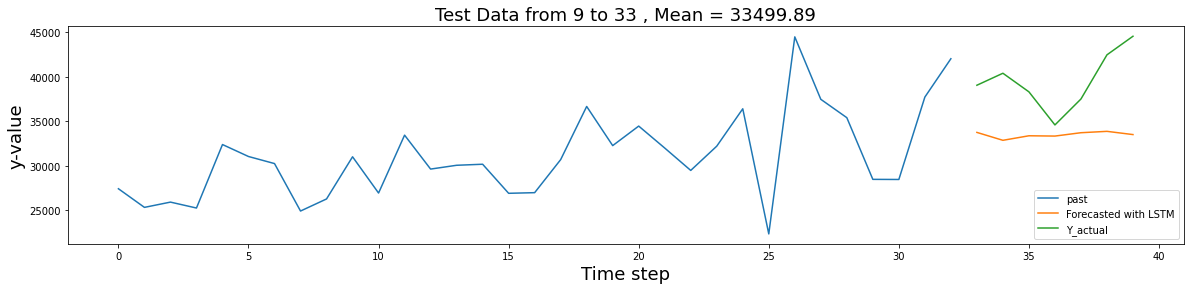

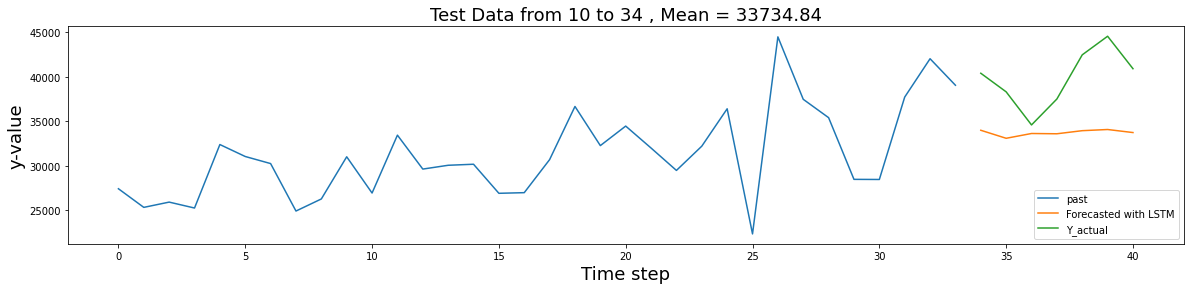

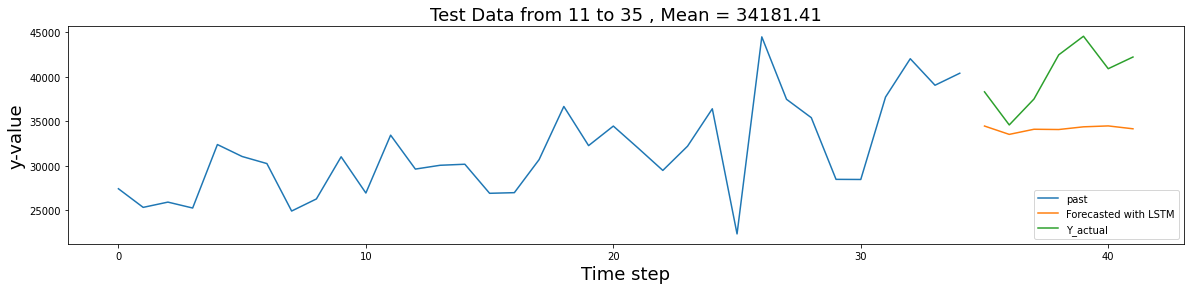

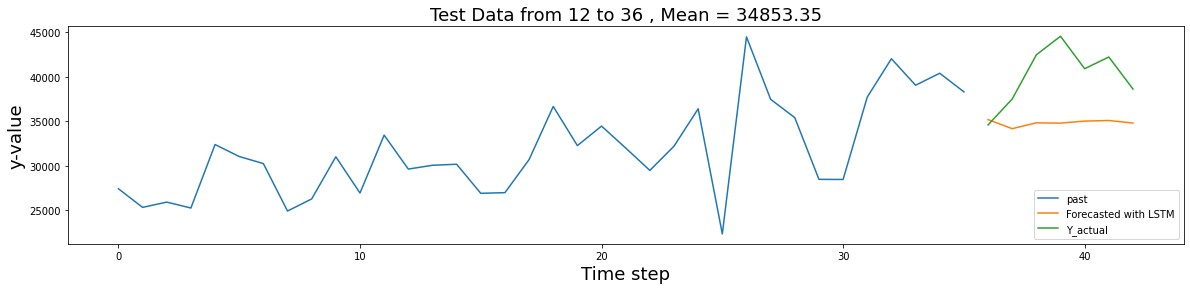

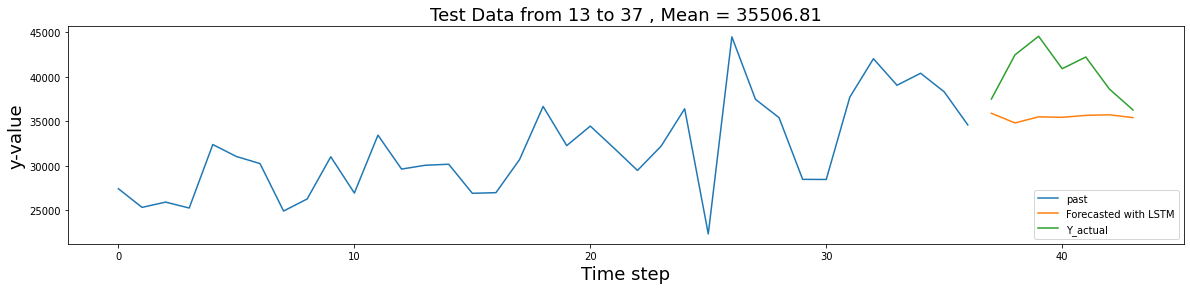

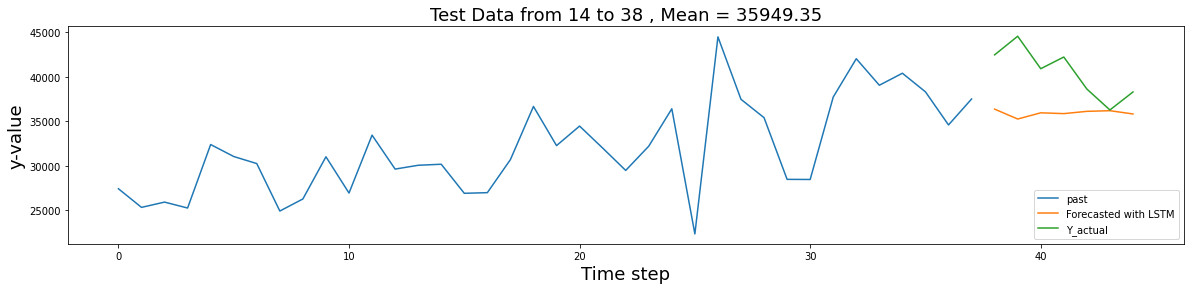

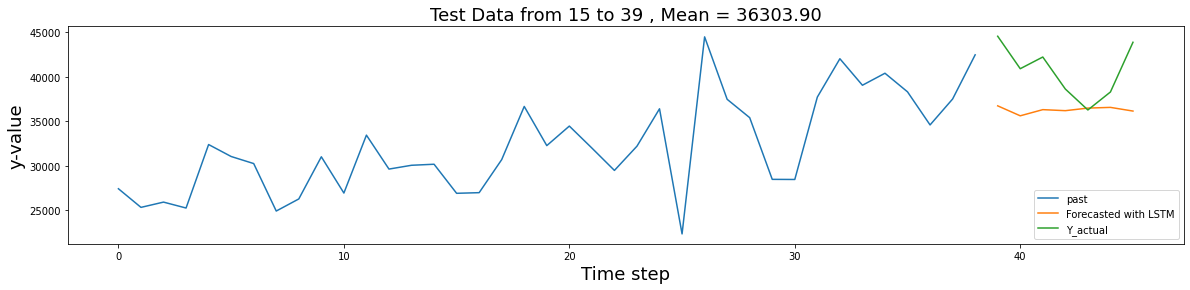

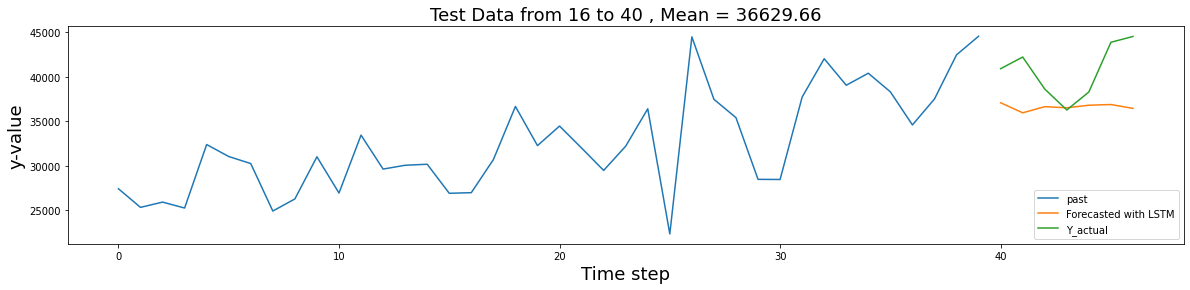

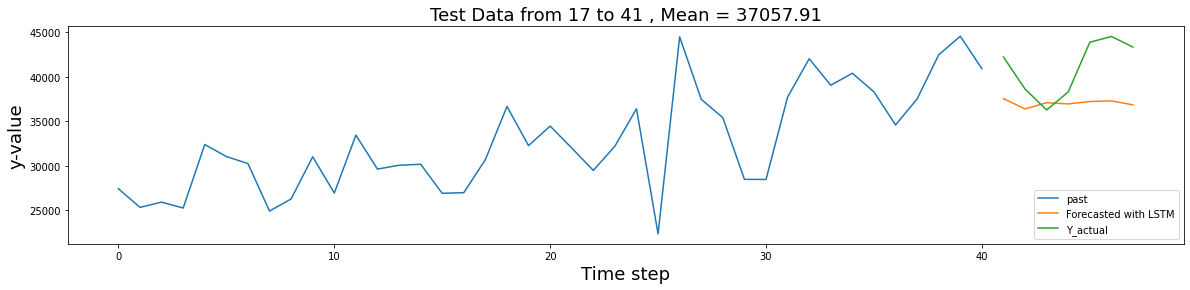

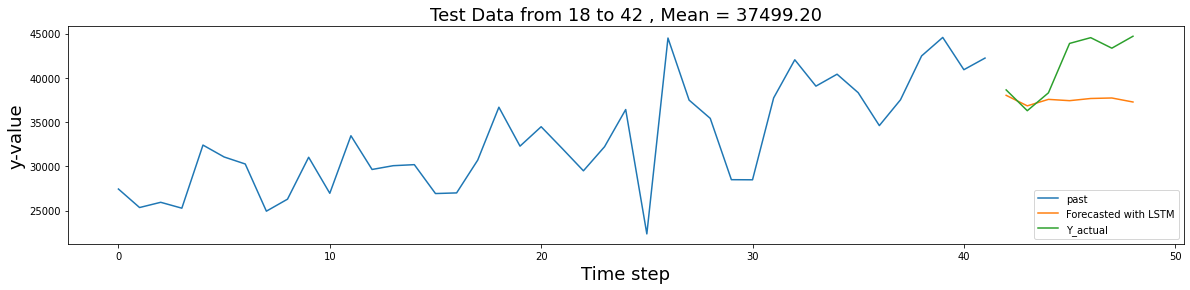

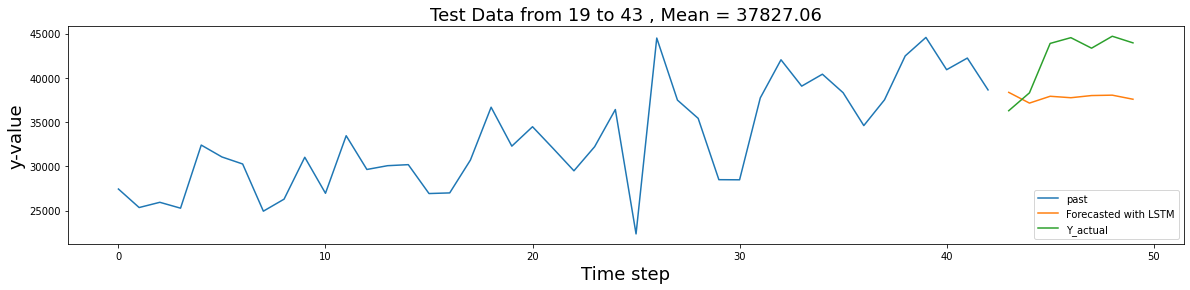

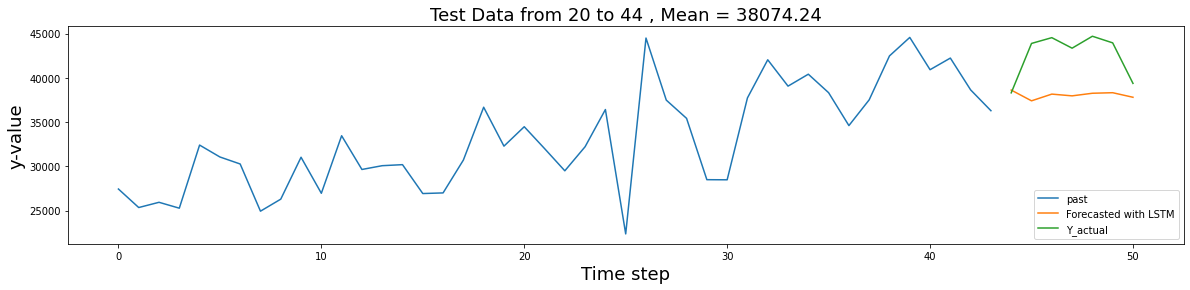

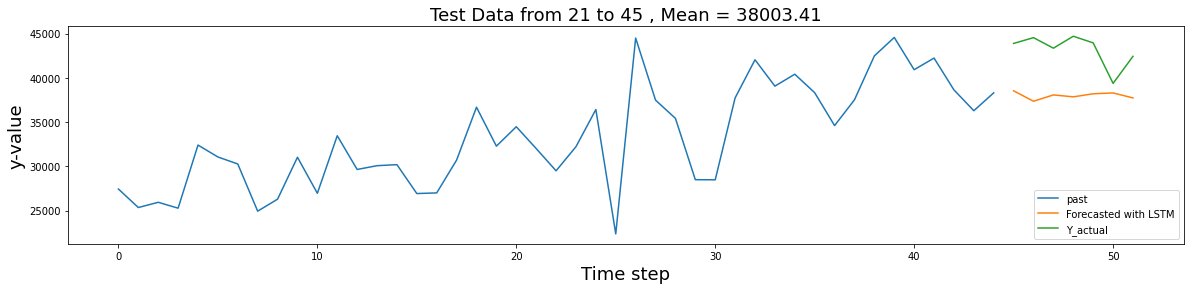

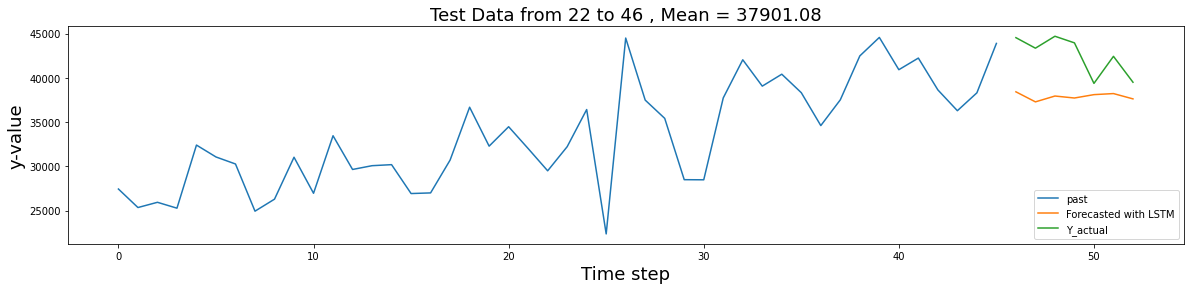

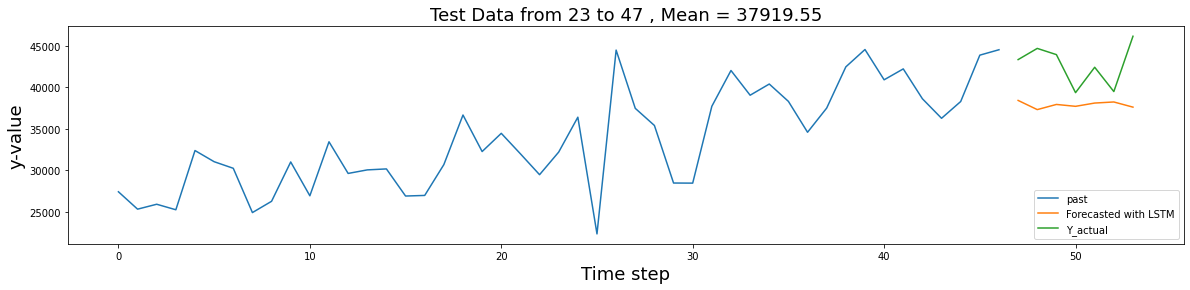

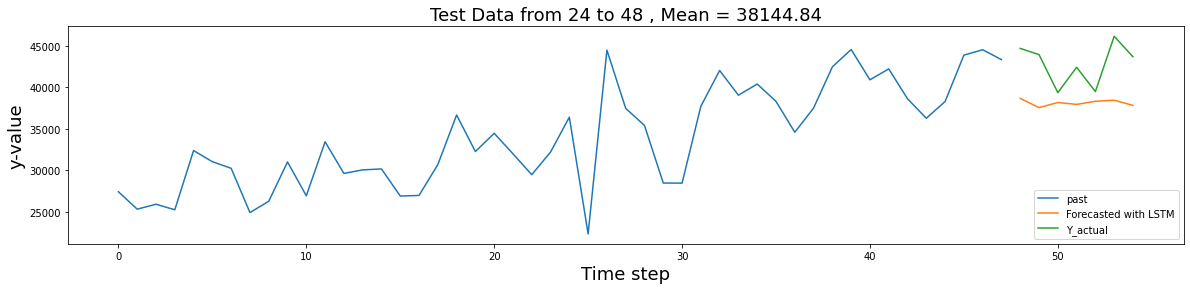

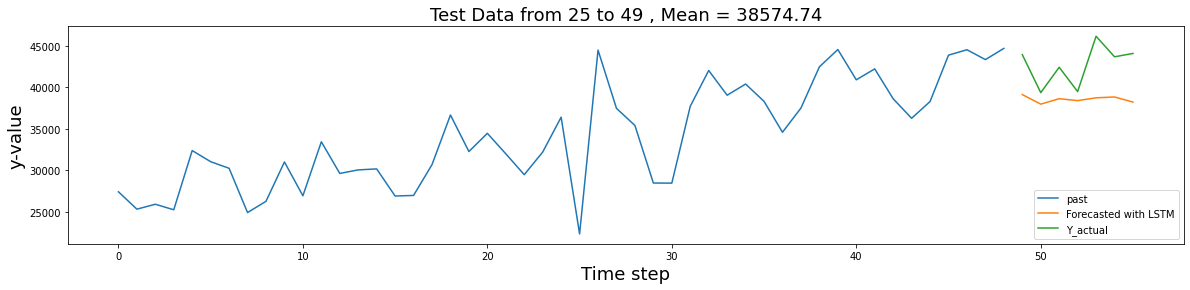

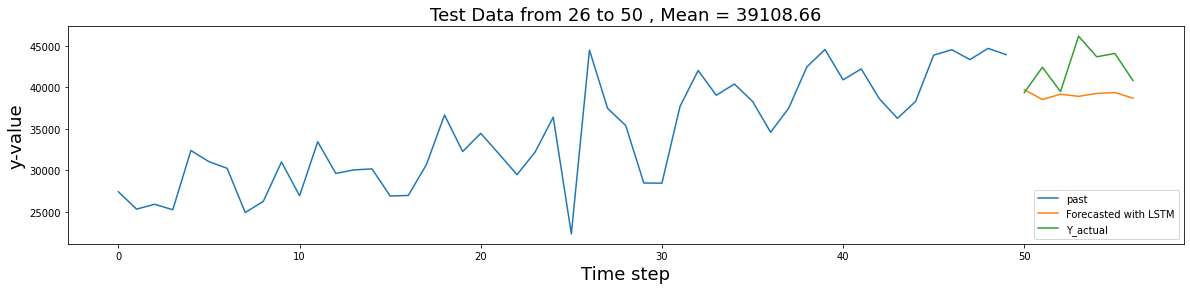

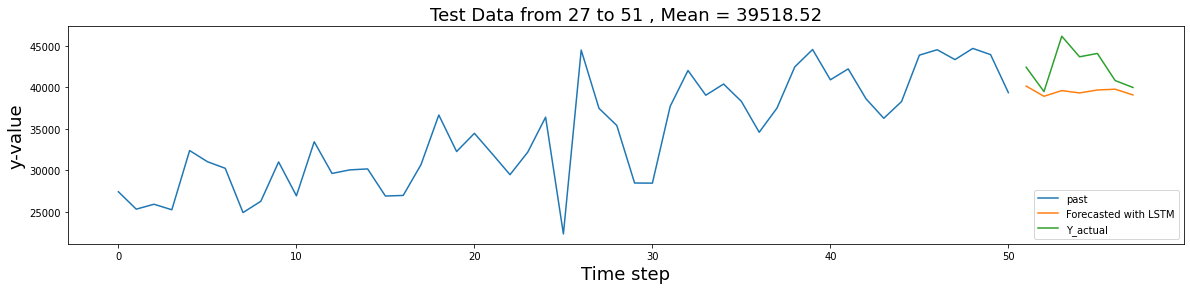

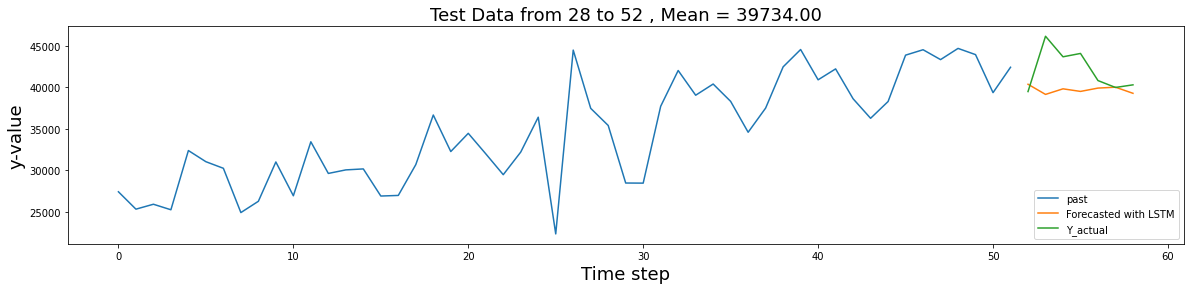

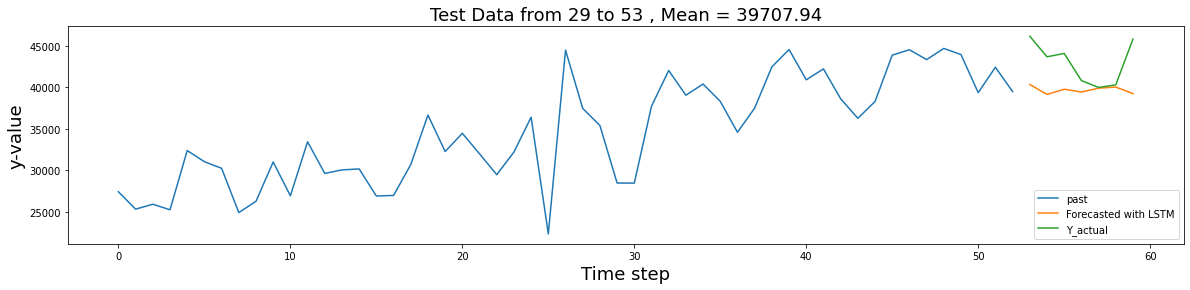

In [91]:
for i in range(0,30,1):
    start = i
    end = start + n_steps_in 
    last = end + n_steps_out 
    pred7, real7, past24 = prep_data(Y_test_scaled,test_Y_pred, start, end, last) 
    evaluate_prediction(pred7, real7 , start , end) 
    plot_multistep(past24 , pred7 , real7 , start , end) 

## GRU

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_4 (GRU)                 (None, 24, 128)           50304     
                                                                 
 dropout_12 (Dropout)        (None, 24, 128)           0         
                                                                 
 gru_5 (GRU)                 (None, 24, 256)           296448    
                                                                 
 dropout_13 (Dropout)        (None, 24, 256)           0         
                                                                 
 gru_6 (GRU)                 (None, 24, 128)           148224    
                                                                 
 dropout_14 (Dropout)        (None, 24, 128)           0         
                                                                 
 gru_7 (GRU)                 (None, 64)               

2022-06-07 18:21:43.433757: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


31/31 [==============================] - 75s 2s/step - loss: 0.1310
Epoch 2/30
31/31 [==============================] - 73s 2s/step - loss: 0.0169
Epoch 3/30
31/31 [==============================] - 74s 2s/step - loss: 0.0137
Epoch 4/30
31/31 [==============================] - 74s 2s/step - loss: 0.0134
Epoch 5/30
31/31 [==============================] - 75s 2s/step - loss: 0.0133
Epoch 6/30
31/31 [==============================] - 74s 2s/step - loss: 0.0130
Epoch 7/30
31/31 [==============================] - 75s 2s/step - loss: 0.0132
Epoch 8/30
31/31 [==============================] - 75s 2s/step - loss: 0.0126
Epoch 9/30
31/31 [==============================] - 73s 2s/step - loss: 0.0124
Epoch 10/30
31/31 [==============================] - 73s 2s/step - loss: 0.0129
Epoch 11/30
31/31 [==============================] - 73s 2s/step - loss: 0.0125
Epoch 12/30
31/31 [==============================] - 73s 2s/step - loss: 0.0126
Epoch 13/30
31/31 [==============================] - 73s 2s/

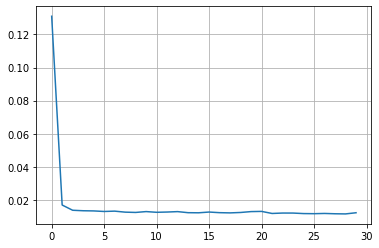

2022-06-07 18:58:09.669945: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [92]:
# gru
model = Sequential()
model.add(GRU(128, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True, activation='relu'))
model.add(Dropout(dropout_ratio)) 
model.add(GRU(256, return_sequences=True, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(GRU(128, return_sequences=True, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(GRU(64, return_sequences=False, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()
model_fit = model.fit(train_X, train_Y, 
                      batch_size=batch_size, epochs=epoch,
                      verbose=verbose)

plt.plot(pd.DataFrame(model_fit.history))
plt.grid(True)
plt.show()

# prediction
train_Y_pred_gru = model.predict(train_X)
test_Y_pred_gru = model.predict(test_X)

Test Data from 0 to 24
Mean Absolute Error: 6232.33
Mean Absolute Percenatge Error: 18.77


Test Data from 1 to 25
Mean Absolute Error: 6367.83
Mean Absolute Percenatge Error: 20.03


Test Data from 2 to 26
Mean Absolute Error: 8286.04
Mean Absolute Percenatge Error: 20.74


Test Data from 3 to 27
Mean Absolute Error: 4171.59
Mean Absolute Percenatge Error: 12.19


Test Data from 4 to 28
Mean Absolute Error: 5426.48
Mean Absolute Percenatge Error: 14.87


Test Data from 5 to 29
Mean Absolute Error: 5736.74
Mean Absolute Percenatge Error: 15.82


Test Data from 6 to 30
Mean Absolute Error: 6765.99
Mean Absolute Percenatge Error: 17.46


Test Data from 7 to 31
Mean Absolute Error: 8299.45
Mean Absolute Percenatge Error: 21.27


Test Data from 8 to 32
Mean Absolute Error: 5892.05
Mean Absolute Percenatge Error: 14.66


Test Data from 9 to 33
Mean Absolute Error: 4565.63
Mean Absolute Percenatge Error: 11.03


Test Data from 10 to 34
Mean Absolute Error: 5096.04
Mean Absolute Percenatge Er

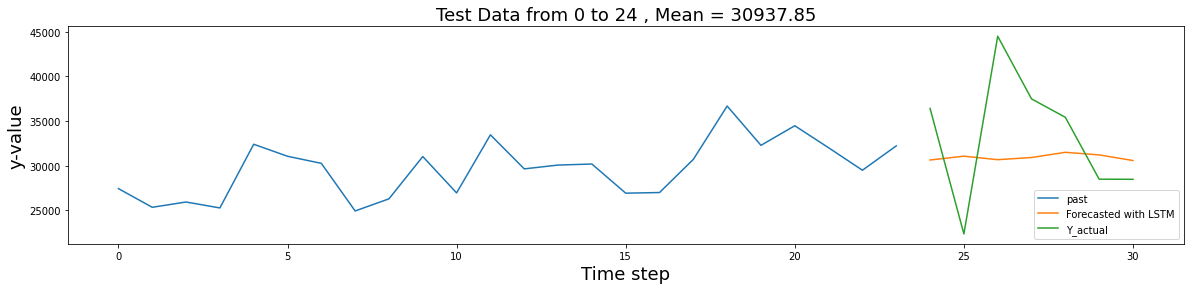

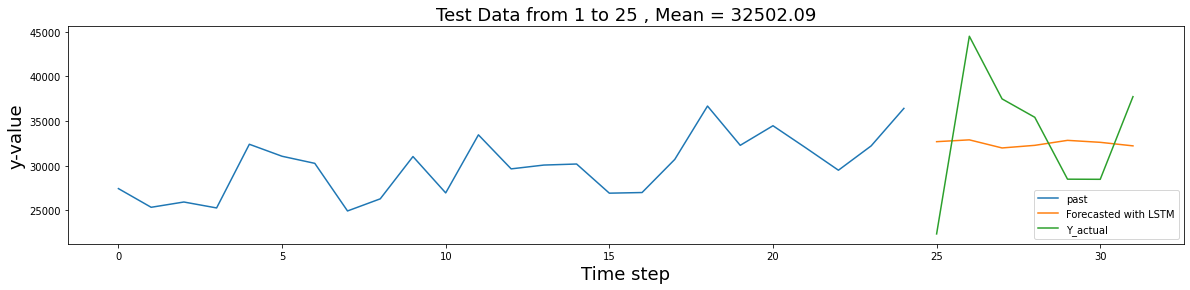

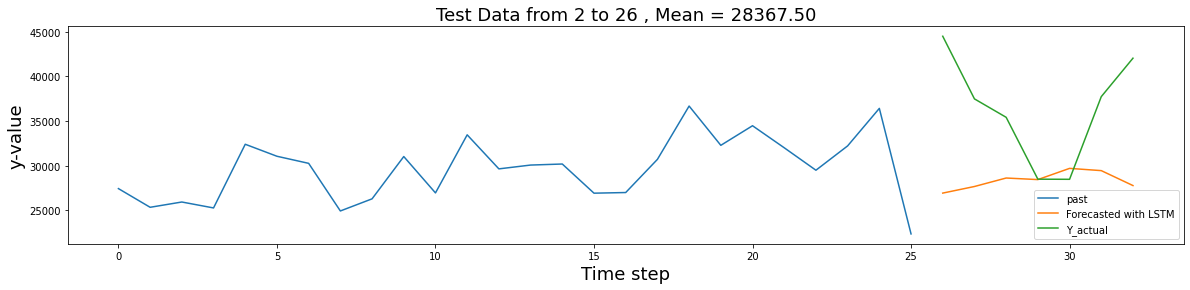

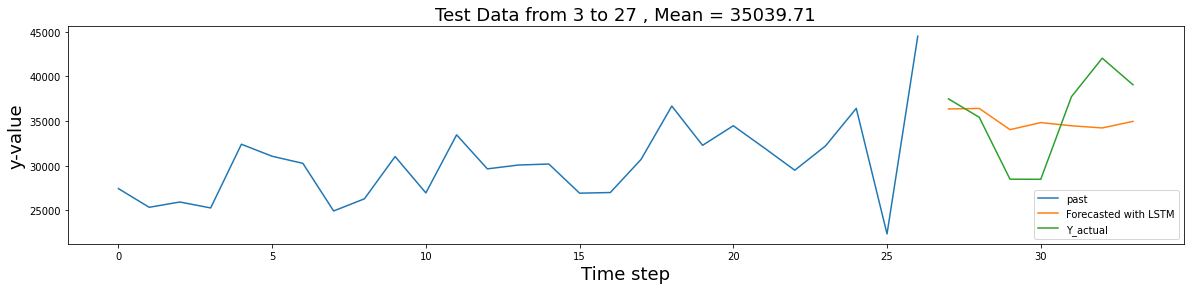

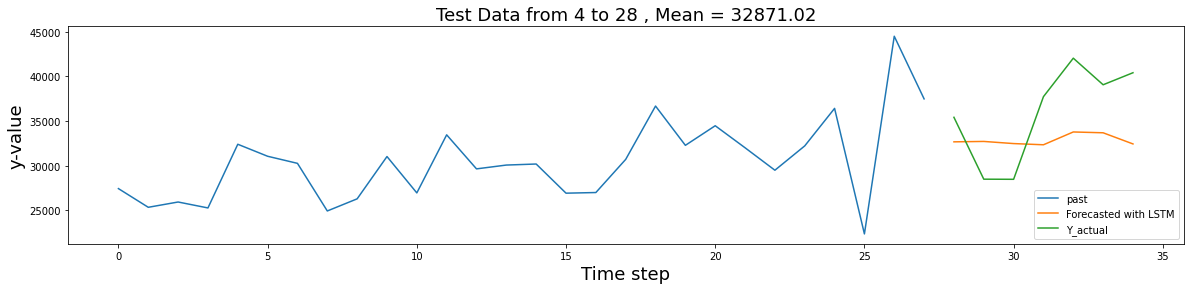

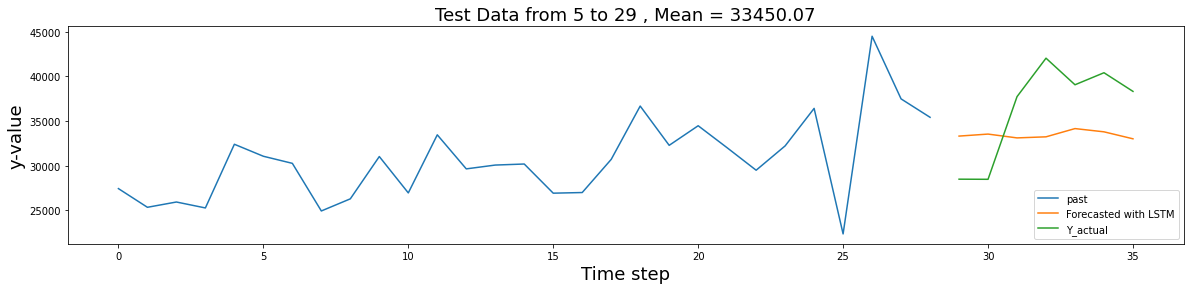

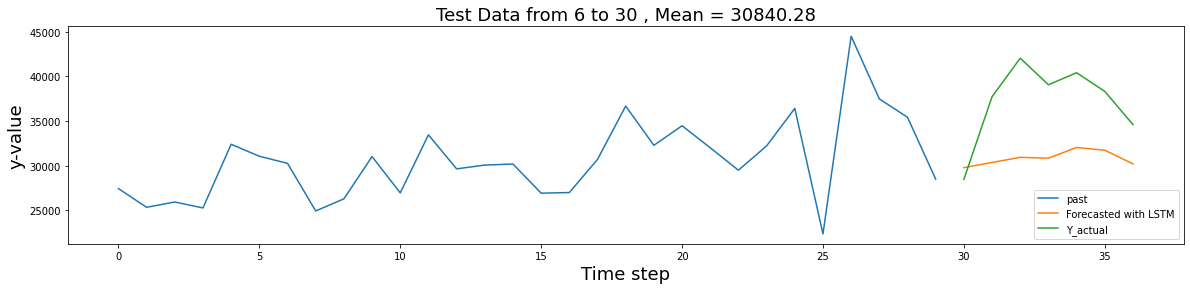

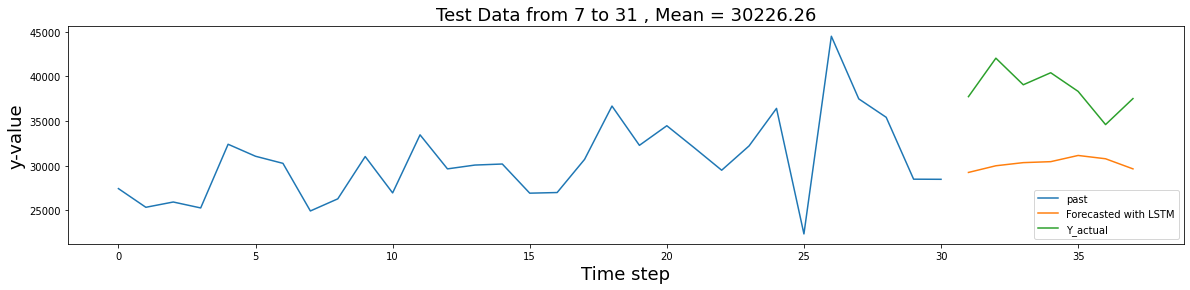

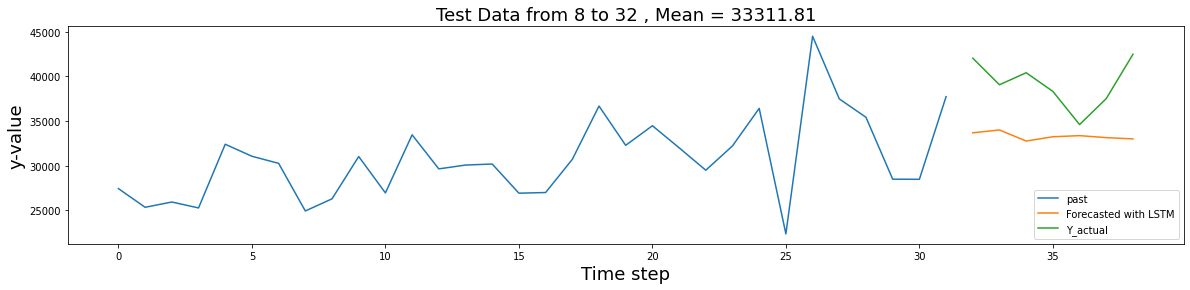

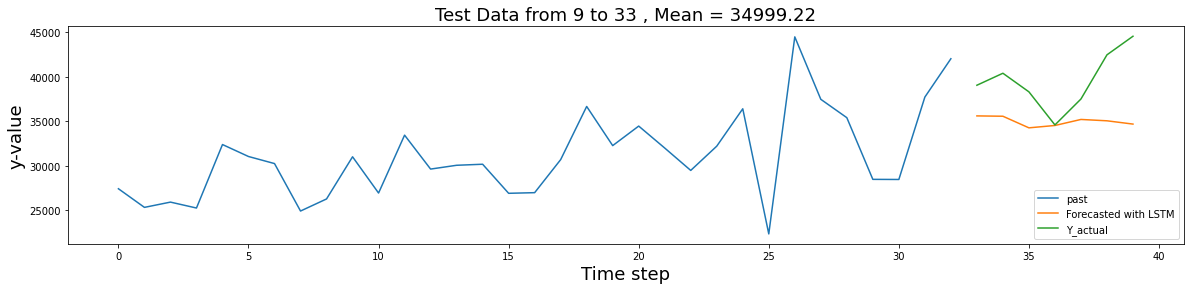

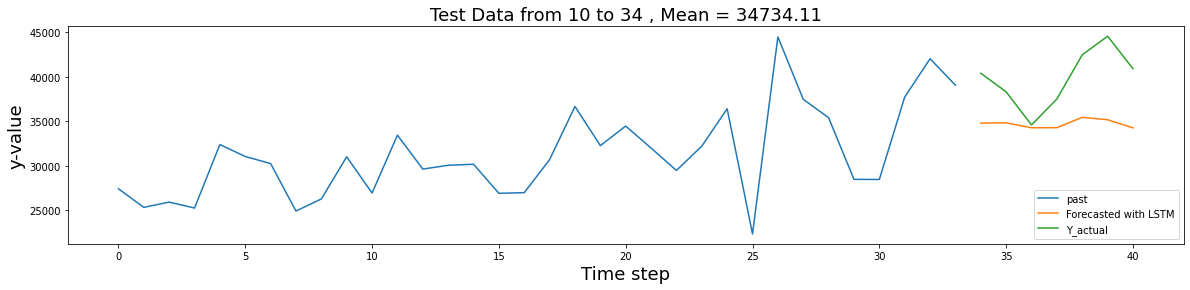

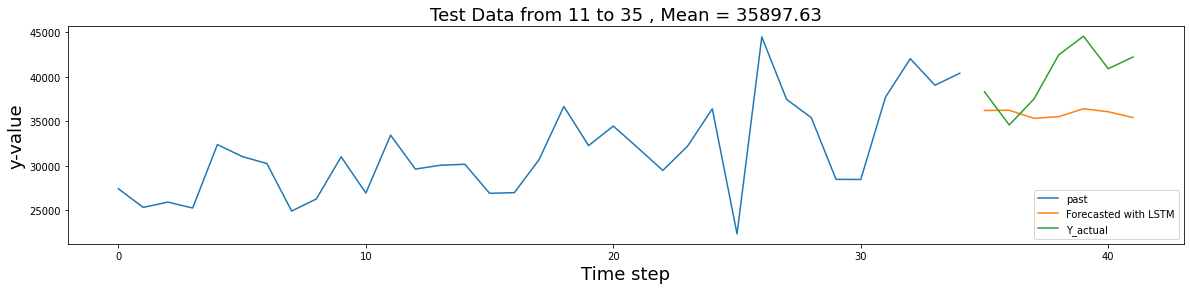

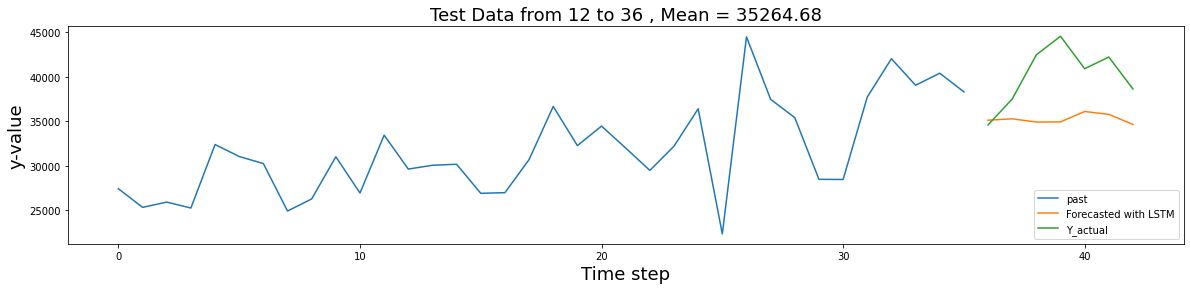

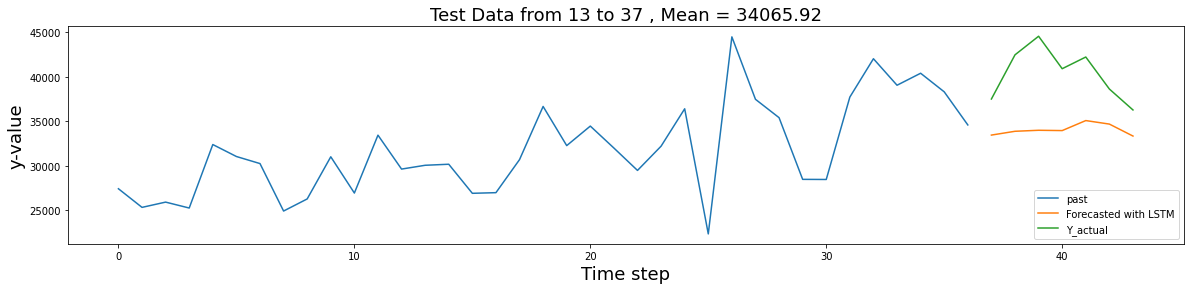

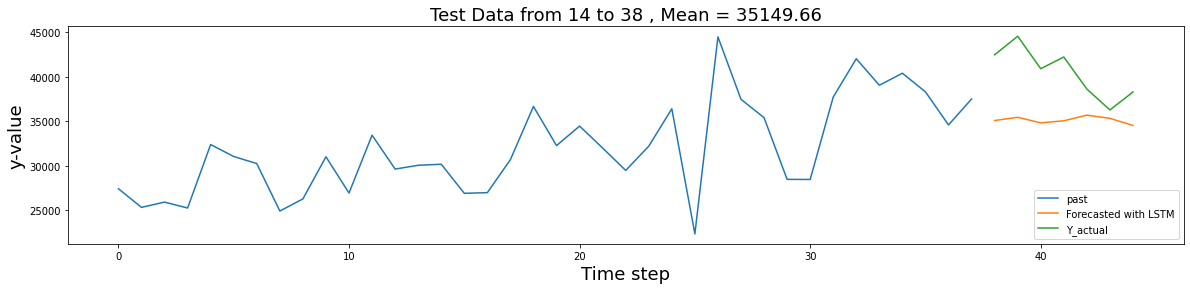

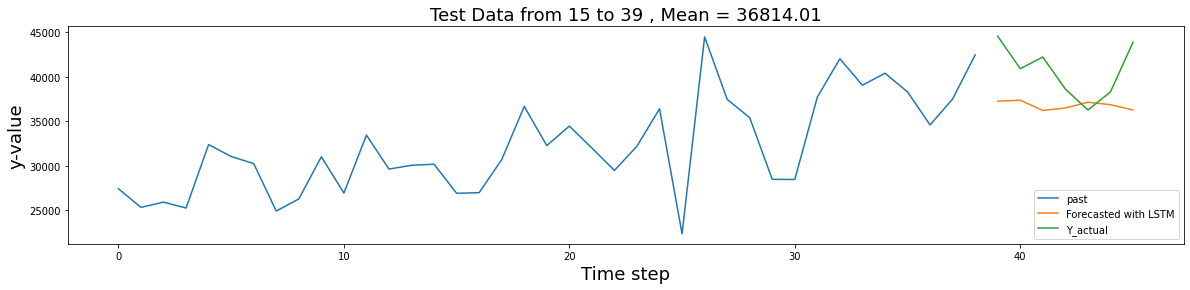

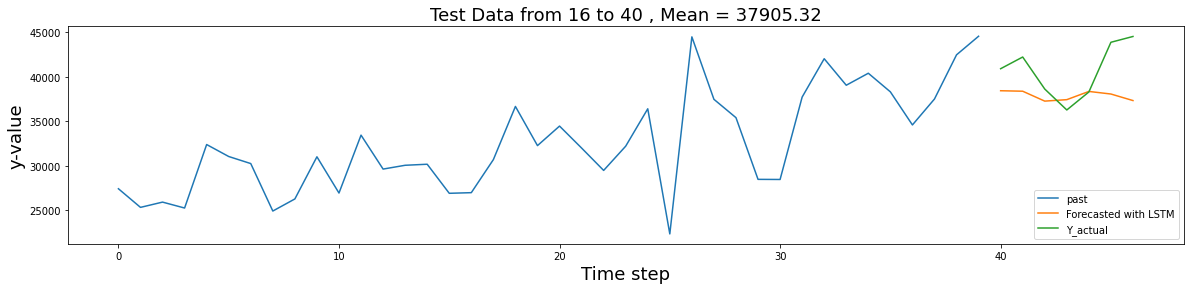

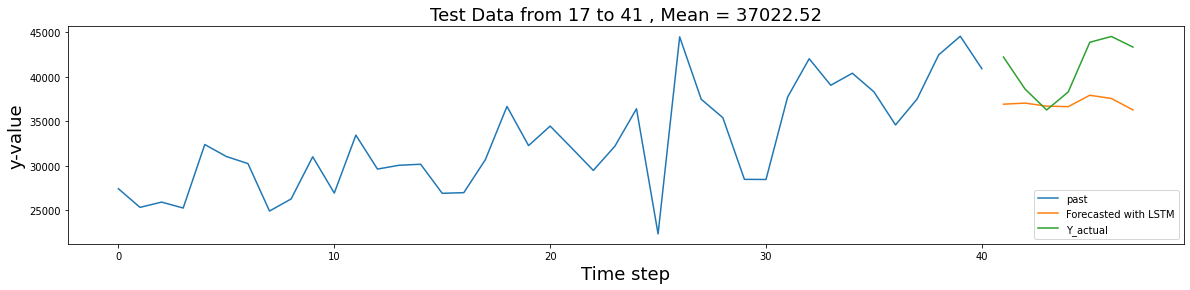

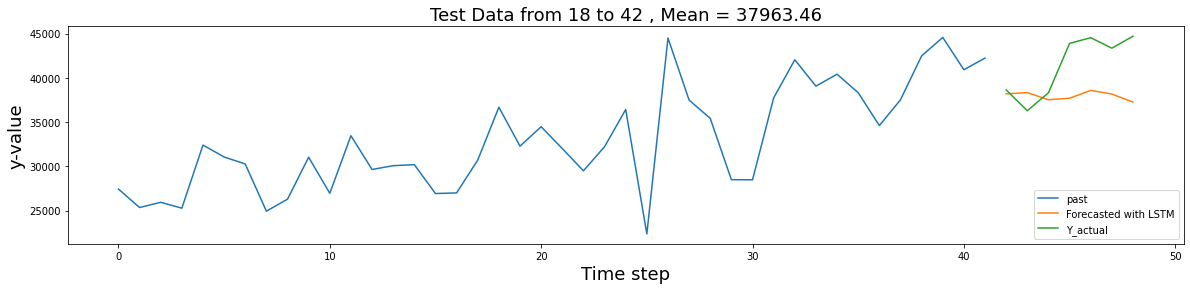

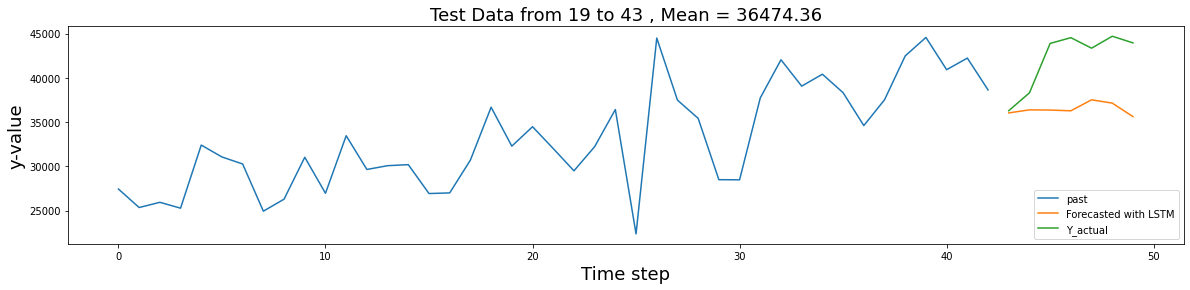

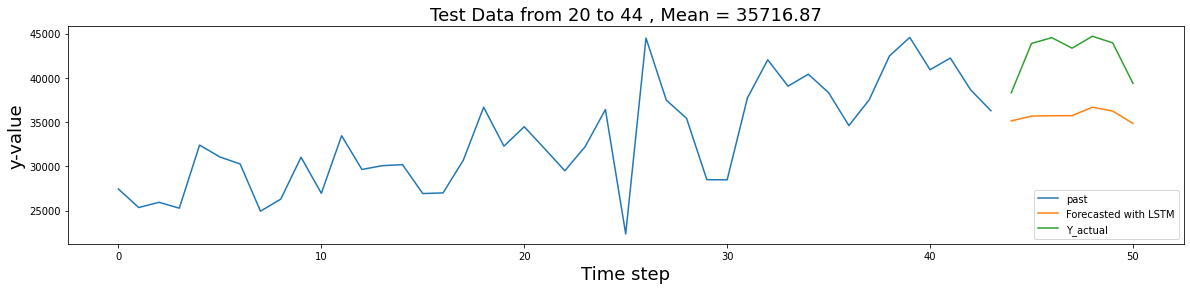

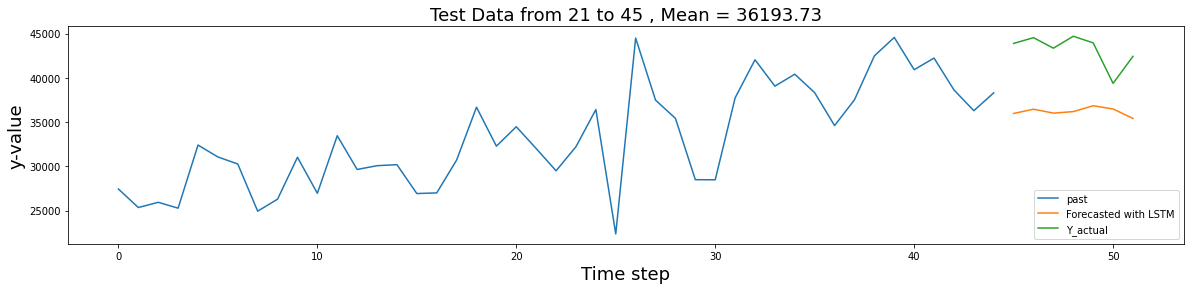

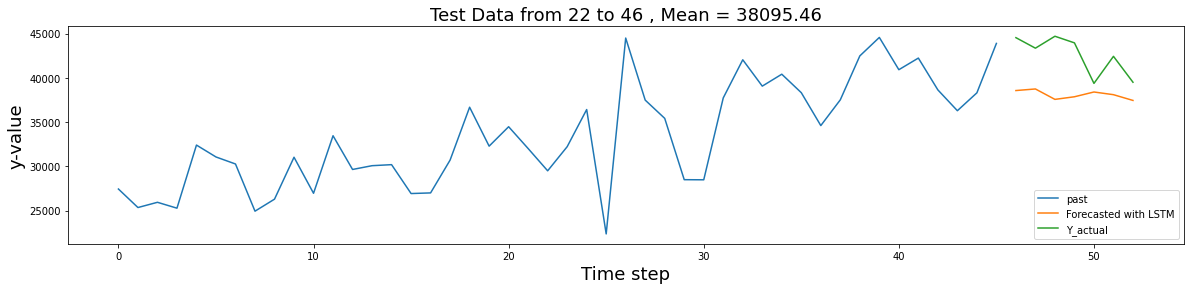

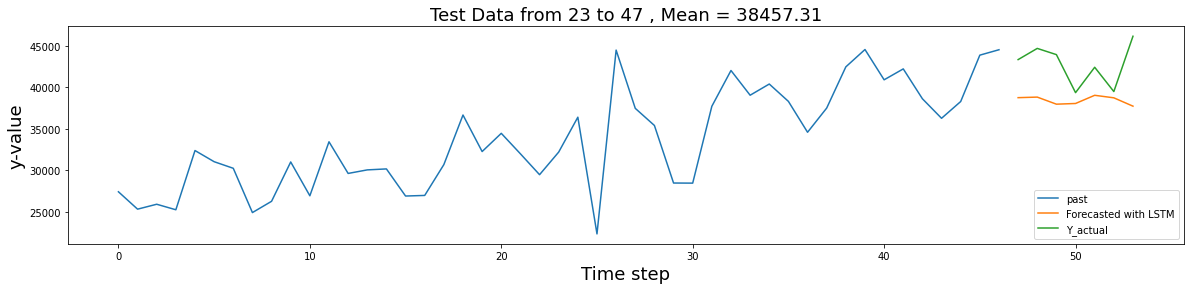

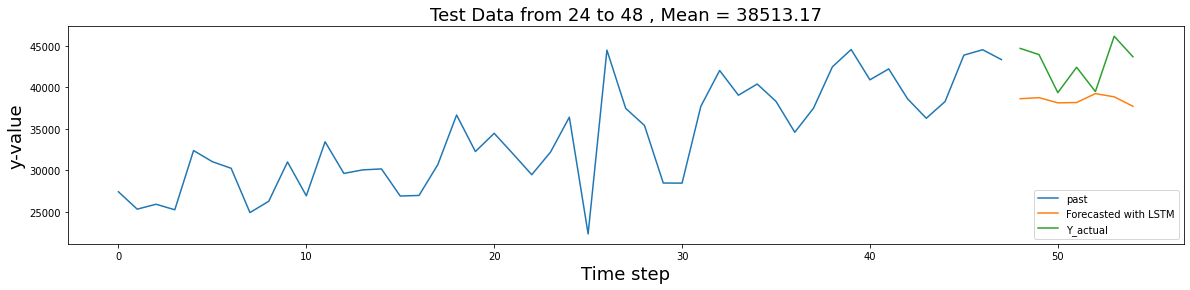

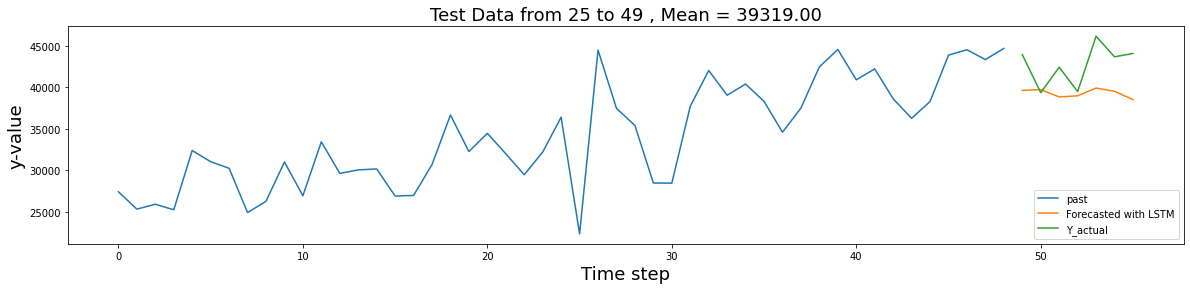

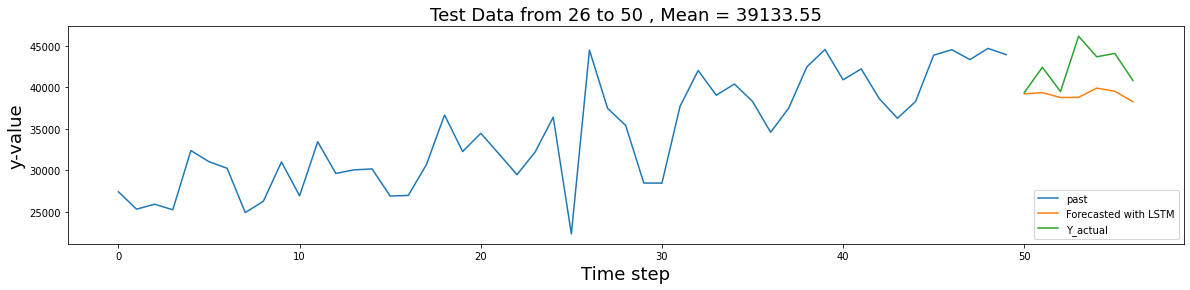

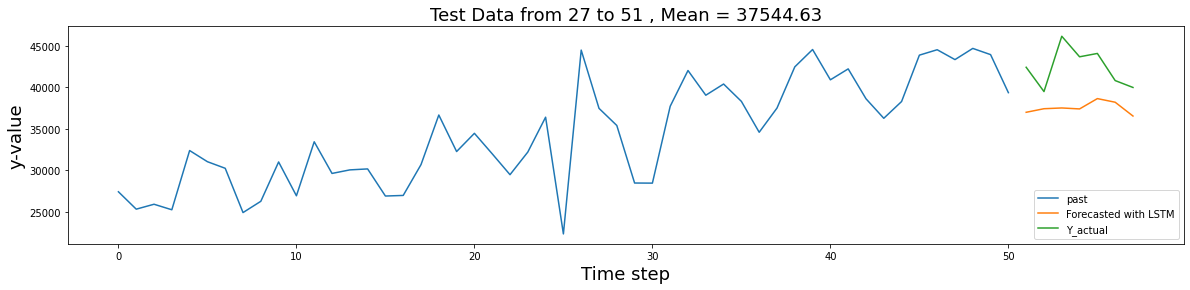

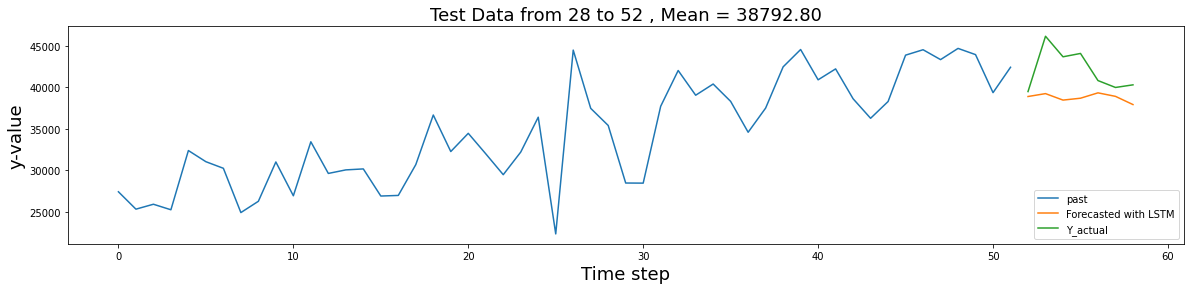

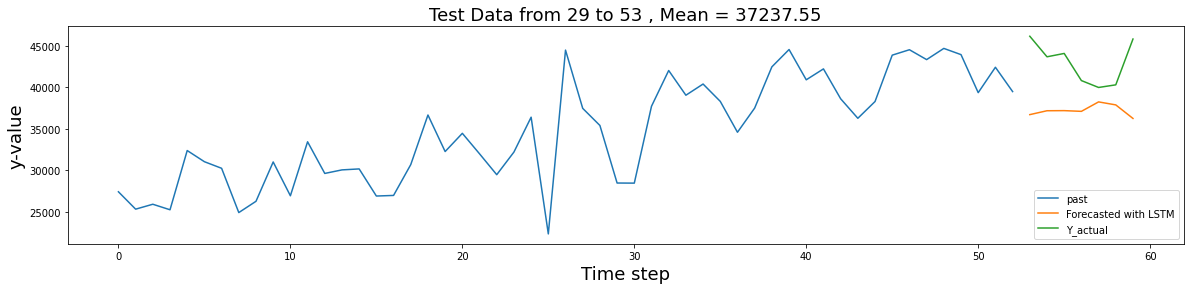

In [93]:
for i in range(0,30,1):
    start = i
    end = start + n_steps_in 
    last = end + n_steps_out 
    pred7, real7, past24 = prep_data(Y_test_scaled,test_Y_pred_gru, start, end, last) 
    evaluate_prediction(pred7, real7 , start , end) 
    plot_multistep(past24 , pred7 , real7 , start , end) 

In [94]:
#pd.DataFrame(Y_test).to_csv('/Users/kimjinseok/Desktop/work/data_science/kaflix_demand forecasting/csv/gru_y_check/uni/uni_Y_test_wd.csv')
#pd.DataFrame(scaler_Y_tr.inverse_transform(Y_test_scaled)).to_csv('/Users/kimjinseok/Desktop/work/data_science/kaflix_demand forecasting/csv/gru_y_check/uni/uni_Y_test.csv')
#pd.DataFrame(scaler_Y_tr.inverse_transform(test_Y_pred_gru)).to_csv('/Users/kimjinseok/Desktop/work/data_science/kaflix_demand forecasting/csv/gru_y_check/uni_test_Y_pred_gru.csv')